# 2.4 CAPM and APT

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import datetime as dt
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

In [4]:
params = {'figure.figsize': (15, 5),
         'axes.labelsize': 14,
         'axes.titlesize': 14,
          'axes.titlesize': 18}
pylab.rcParams.update(params)

# 2.4.1

In [5]:
df = pd.read_csv(r'/Users/desmond/Desktop/FSP_CW/all/Section 2/data/fsp_case_31_BSD.csv',index_col=0,header=[0,1])
df.fillna(value=0,inplace=True)
#returns dataframe
df_returns = df['ret']
date_axis = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in df_returns.index]
df_returns.shape

(521, 157)

In [6]:
a = df_returns.rolling(22,min_periods=22).mean().dropna()

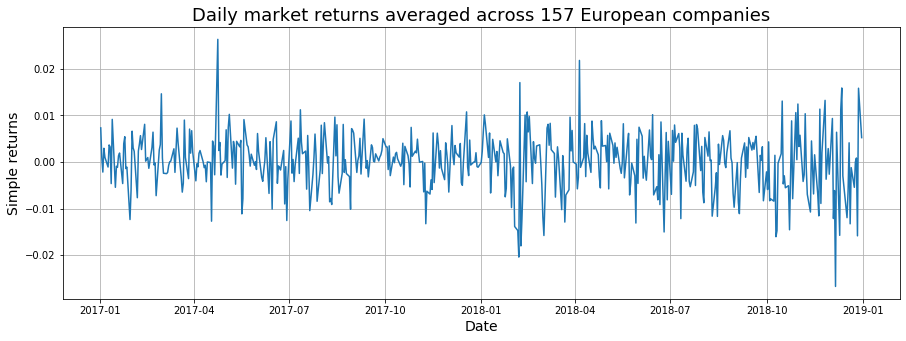

In [7]:
rmt = np.mean(df_returns,1)
plt.figure()
plt.plot(date_axis,rmt)
plt.grid('major',axis='both')
plt.xlabel('Date')
plt.ylabel('Simple returns')
plt.title('Daily market returns averaged across 157 European companies')
#plt.savefig('/Users/desmond/Desktop/FSP_CW/all/Section 2/eps_files/241.eps')

# 2.4.2

In [8]:
#Beta = Cov(Ri,Rm) / Var(Rm)
win = 22
betas = np.zeros((len(df)-win+1,df['ret'].shape[1]))
for i in range(df['ret'].shape[1]):
    for j in range(len(df)-win+1):
        betas[j,i] = df['ret'].iloc[j:win+j,i].cov(rmt.iloc[j:win+j])/rmt.iloc[j:win+j].var()

In [9]:
df['ret']['G_AALLN'].rolling(22).cov(rmt).dropna()

2017-01-31    0.000027
2017-02-01    0.000030
2017-02-02    0.000030
2017-02-03    0.000023
2017-02-06    0.000027
                ...   
2018-12-25    0.000196
2018-12-26    0.000202
2018-12-27    0.000213
2018-12-28    0.000228
2018-12-31    0.000218
Length: 500, dtype: float64

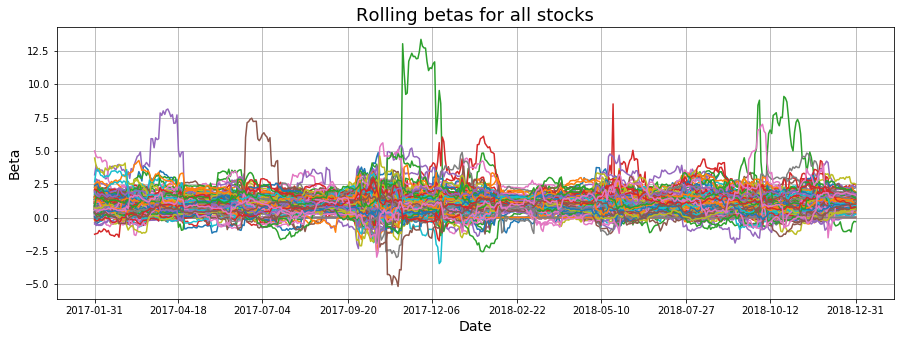

In [10]:
plt.figure()
plt.plot(df.iloc[21:,:].index,betas)
plt.xticks([df.iloc[21:,:].index[i] for i in np.linspace(0,len(df.iloc[21:,:])-1,10).astype(int)])
plt.xlabel('Date')
plt.ylabel('Beta')
plt.title('Rolling betas for all stocks')
plt.grid('major',axis='both')
plt.tight_layout
#plt.savefig('/Users/desmond/Desktop/FSP_CW/all/Section 2/eps_files/242.eps')

# 2.4.3

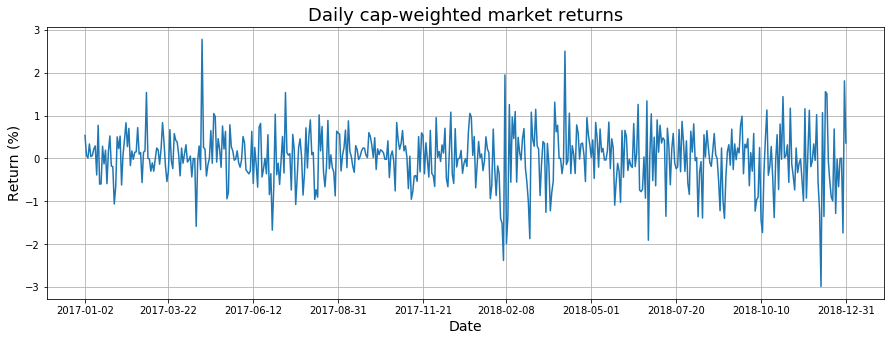

In [11]:
daily_total_mcap = df['mcap'].sum(axis=1)
mcap_times_return = np.multiply(df['mcap'],df['ret']).sum(axis=1)
daily_weighted_return = mcap_times_return / daily_total_mcap
percentage_return = 100 * daily_weighted_return
plt.figure()
plt.plot(percentage_return)
plt.xticks([percentage_return.index[i] for i in np.linspace(0,len(percentage_return.index)-1,10).astype(int)])
plt.grid('major',axis='both')
plt.xlabel('Date')
plt.ylabel('Return (%)')
plt.title('Daily cap-weighted market returns')
#plt.savefig('/Users/desmond/Desktop/FSP_CW/all/Section 2/eps_files/243.eps')

# 2.4.4

In [12]:
#Beta = Cov(Ri,Rm) / Var(Rm)
win = 22
cap_weighted_betas = np.zeros((len(df)-win+1,df['ret'].shape[1]))
for i in range(df['ret'].shape[1]):
    for j in range(len(df)-win+1):
        cap_weighted_betas[j,i] = np.cov(df['ret'].iloc[j:win+j,i],(daily_weighted_return.iloc[j:win+j]))[1,0]/daily_weighted_return.iloc[j:win+j].var()

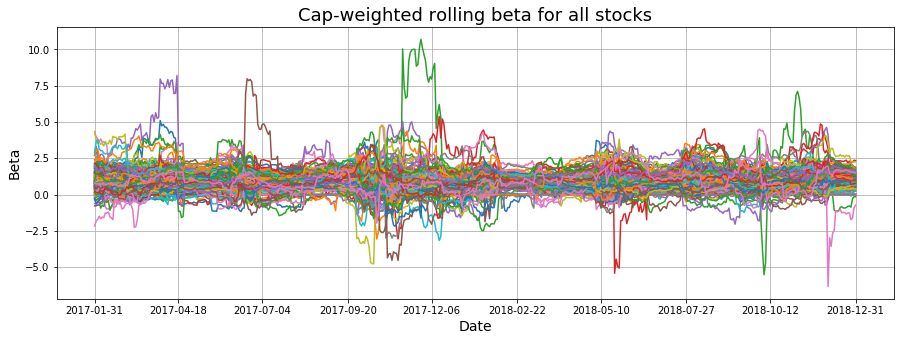

In [13]:
plt.figure()
plt.plot(df.iloc[21:,:].index,cap_weighted_betas)
plt.xticks([df.iloc[21:,:].index[i] for i in np.linspace(0,len(df.iloc[21:,:])-1,10).astype(int)])
plt.xlabel('Date')
plt.ylabel('Beta')
plt.title('Cap-weighted rolling beta for all stocks')
plt.grid('major',axis='both')
plt.tight_layout
#plt.savefig('/Users/desmond/Desktop/FSP_CW/all/Section 2/eps_files/244.eps')

In [14]:
betas_pd = pd.DataFrame(betas.T,index=df['mcap'].T.index).T
cap_weighted_betas_pd = pd.DataFrame(cap_weighted_betas.T,index=df['mcap'].T.index).T

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


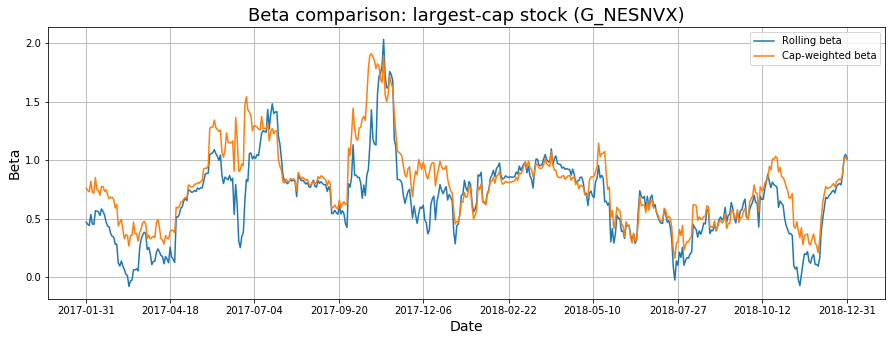

In [15]:

plt.figure()
plt.plot(df.iloc[21:,:].index,betas_pd.T.loc['G_NESNVX'])
plt.plot(cap_weighted_betas_pd.T.loc['G_NESNVX'])
plt.xticks([df.iloc[21:,:].index[i] for i in np.linspace(0,len(df.iloc[21:,:])-1,10).astype(int)])
plt.title('Beta comparison: largest-cap stock (G_NESNVX)')
plt.xlabel('Date')
plt.ylabel('Beta')
plt.legend(['Rolling beta','Cap-weighted beta'])
plt.grid('major',axis='both')
#plt.savefig('/Users/desmond/Desktop/FSP_CW/all/Section 2/eps_files/largestcap.eps')

# 2.4.5 a)

In [16]:
bs = df['mcap'].rolling(22).mean().dropna().apply(np.log).replace([np.inf, -np.inf],0).T
bm = cap_weighted_betas.T
ri = df['ret'].iloc[21:,:].T

In [17]:
def apt_regression(factor,ri,bm,bs):
    coeffs = np.zeros((factor,1))
    a = np.zeros((1,1))
    resid = np.zeros((ri.shape[0],1))
    for i in range(ri.shape[1]):
        X = np.concatenate([[bm[:,i],bs.values[:,i]]]).T
        y = ri.values[:,[i]]
        reg = LinearRegression()
        reg.fit(X,y)
        #print(coeffs.shape)
        coeffs = np.append(coeffs,reg.coef_.T,axis=1)
        a = np.append(a,reg.intercept_)
        resid = np.append(resid,reg.predict(X) - ri.values[:,[i]],axis=1)
    
    Rm = coeffs[0,:]
    Rs = coeffs[1,:]
    pred = np.multiply(Rm[1:],bm)+ np.multiply(Rs[1:],bs) + a[1:]
    resid = ri - pred

    return Rm[1:], Rs[1:], a[1:], resid

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


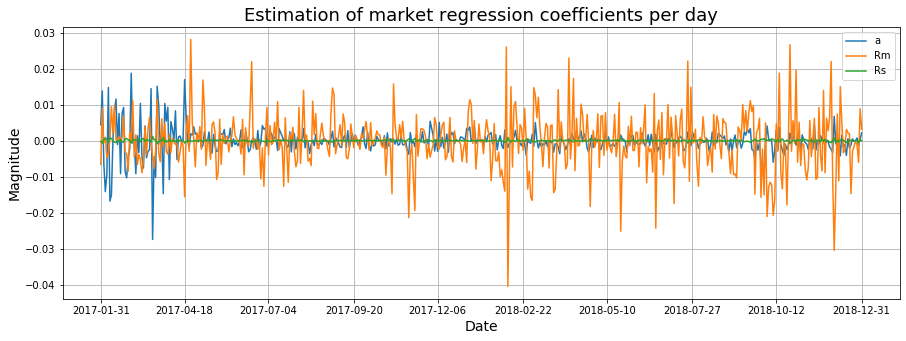

In [18]:
factor = 2
Rm, Rs, a, resid = apt_regression(factor,ri,bm,bs)

plt.figure()
plt.plot(df.iloc[21:,:].index,a)
plt.plot(df.iloc[21:,:].index,Rm)
plt.plot(df.iloc[21:,:].index,Rs)
plt.xticks([df.iloc[21:,:].index[i] for i in np.linspace(0,len(df.iloc[21:,:].index)-1, 10).astype(int)])
plt.title('Estimation of market regression coefficients per day')
plt.xlabel('Date')
plt.ylabel('Magnitude')
plt.legend(['a','Rm','Rs'])
plt.grid('major',axis='both')
#plt.savefig('/Users/desmond/Desktop/FSP_CW/all/Section 2/eps_files/245a.eps')

# 2.4.5  b)

In [19]:
mean_a = np.mean(a)
std_a = np.std(a)
mean_Rm = np.mean(Rm)
std_Rm = np.std(Rm)
mean_Rs = np.mean(Rs)
std_Rs = np.std(Rs)
stats = pd.DataFrame(data=[[mean_a, std_a],[mean_Rm,std_Rm],[mean_Rs,std_Rs]],index=['a','Rm','Rs'],columns=['mean','std'])

In [20]:
stats

mean       std
a  -0.000068  0.003663
Rm -0.000306  0.007825
Rs  0.000017  0.000234

In [21]:
print(ri.shape,resid.shape,a.shape,Rm.shape,Rs.shape)

(157, 500) (157, 500) (500,) (500,) (500,)


In [22]:
ri.index

Index(['G_AALLN', 'G_ABIBB', 'G_ACFP', 'G_ADENVX', 'G_ADLERR', 'G_ADNA',
       'G_AFFP', 'G_AIFP', 'G_AIRFP', 'G_AKZANA',
       ...
       'G_TUIGR', 'G_UNANA', 'G_UPMFH', 'G_VIEFP', 'G_VIVFP', 'G_VLVY',
       'G_VOD', 'G_VW', 'G_WKLNA', 'G_WPPLN'],
      dtype='object', name='cmp_id', length=157)

# 2.4.5 c)

(157,)


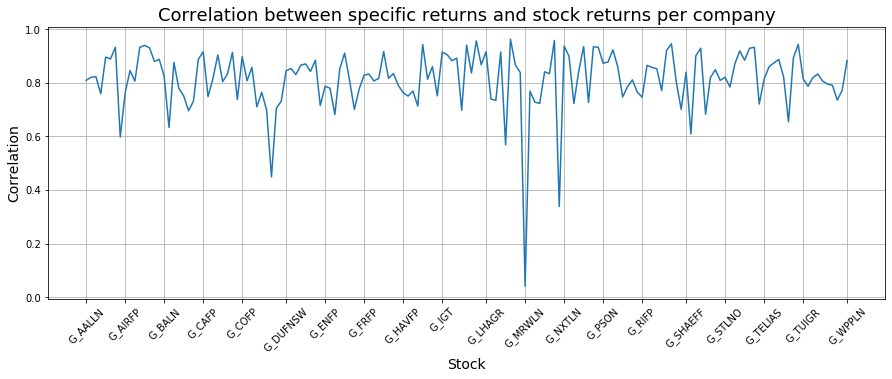

In [23]:
corr_all = np.zeros((ri.shape[0]))
for i in range(ri.shape[0]):
    #corr, _ = pearsonr(resid.T[:,i],ri.values.T[:,i])
    corr = np.corrcoef(resid.T.iloc[:,i],ri.values.T[:,i])[0,1]
    corr_all[i] = corr
print(corr_all.shape)
plt.figure()
plt.plot(ri.index,corr_all)
plt.xticks([ri.index[i] for i in np.linspace(0,len(ri.index)-1,20).astype(int)],rotation=45)
plt.title('Correlation between specific returns and stock returns per company')
plt.xlabel('Stock')
plt.ylabel('Correlation')
plt.grid('major',axis='both')
#plt.savefig('/Users/desmond/Desktop/FSP_CW/all/Section 2/eps_files/245c.eps')

# 2.4.5 d)

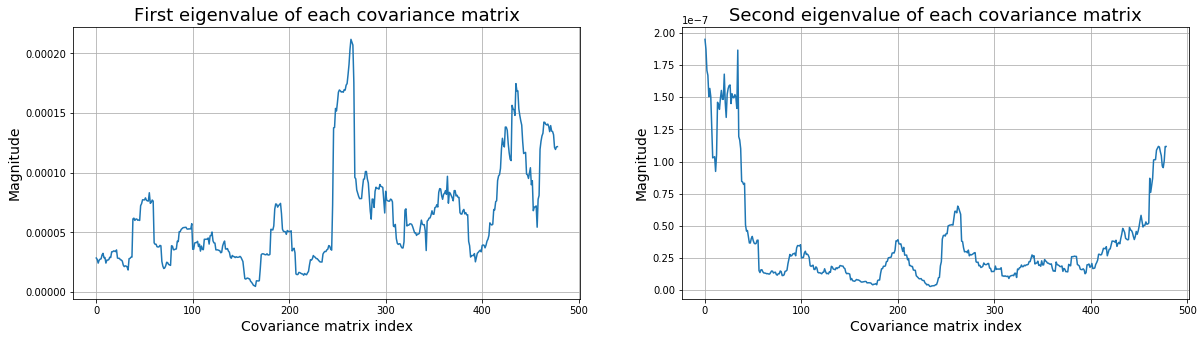

In [24]:
R_ = np.append(Rm.reshape(500,1),Rs.reshape(500,1),axis=1)
eigR_all = np.zeros((2,len(R_)-win+1))
for i in range(len(R_)-win+1):
    covR = np.cov(R_[i:win+i,:].T)
    eigR, _ = np.linalg.eig(covR)
    eigR_all[:,i] = eigR.T
    
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(eigR_all[0,:])
plt.xlabel('Covariance matrix index')
plt.ylabel('Magnitude')
plt.title('First eigenvalue of each covariance matrix')
plt.grid('major',axis='both')
plt.subplot(122)
plt.plot(eigR_all[1,:])
plt.xlabel('Covariance matrix index')
plt.ylabel('Magnitude')
plt.title('Second eigenvalue of each covariance matrix')
plt.grid('major',axis='both')
#plt.savefig('/Users/desmond/Desktop/FSP_CW/all/Section 2/eps_files/245d.eps')

# 2.4.5 e)

0.2830590752826653


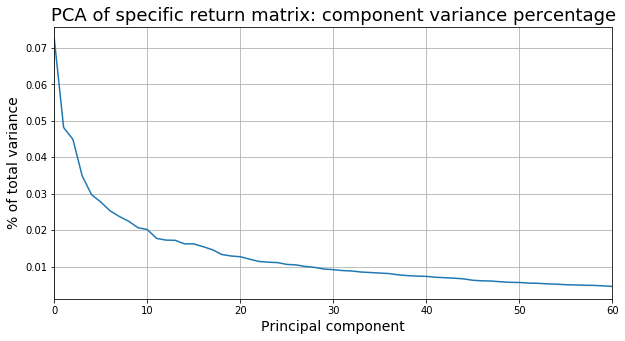

In [30]:
cov_e = np.cov(resid.T)
pca = PCA(n_components=61)
pca.fit(resid)
print(pca.explained_variance_ratio_[0:7].sum())

plt.figure(figsize=(10,5))
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Principal component')
plt.ylabel('% of total variance')
plt.title('PCA of specific return matrix: component variance percentage')
plt.xlim([0,60])
plt.grid('major',axis='both')
#plt.savefig('/Users/desmond/Desktop/FSP_CW/all/Section 2/eps_files/245e.eps')

In [26]:
"""covariance matrix generated from original dataset
eigendecomposition/SVD of covariance matrix
sort eigendecomposition matrices by eigenvalue magnitude
The eigenvalue matrix, by mathematical definition, contains the variance components of dataset feature space
the eigenvector matrix is therefore also sorted by the corresponding eigenvalue magnitude
select n principal components - choose n eigenvectors with the highest variance
Project dataset onto principal components to reduce original dataset dimension

Each principal component contains a percentage of total dataset variance
If 5 principal components contains 80% of the total variance

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-26-d83f65f22951>, line 10)